In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
def RandomFunction(x):
    n = 5
    N = np.arange(1, n, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, phi = 0, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        List_y.append(np.random.randn(1)*function(x + phi))
    
    y = np.array(List_y[0])
    
    for i in range(1, t):
        y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 4 + np.random.randint(0, 20)
        phi = np.random.rand(1)*2*np.pi
        function = np.sin
        if np.random.rand() < -4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, phi = phi, k = np.random.randint(1, 2), function=function)
        T1.append(series)
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [5]:
X_train = GeneratorOfTimeSeries(n = 400, m = 16384)

X_test = GeneratorOfTimeSeries(n = 400, m = 8)

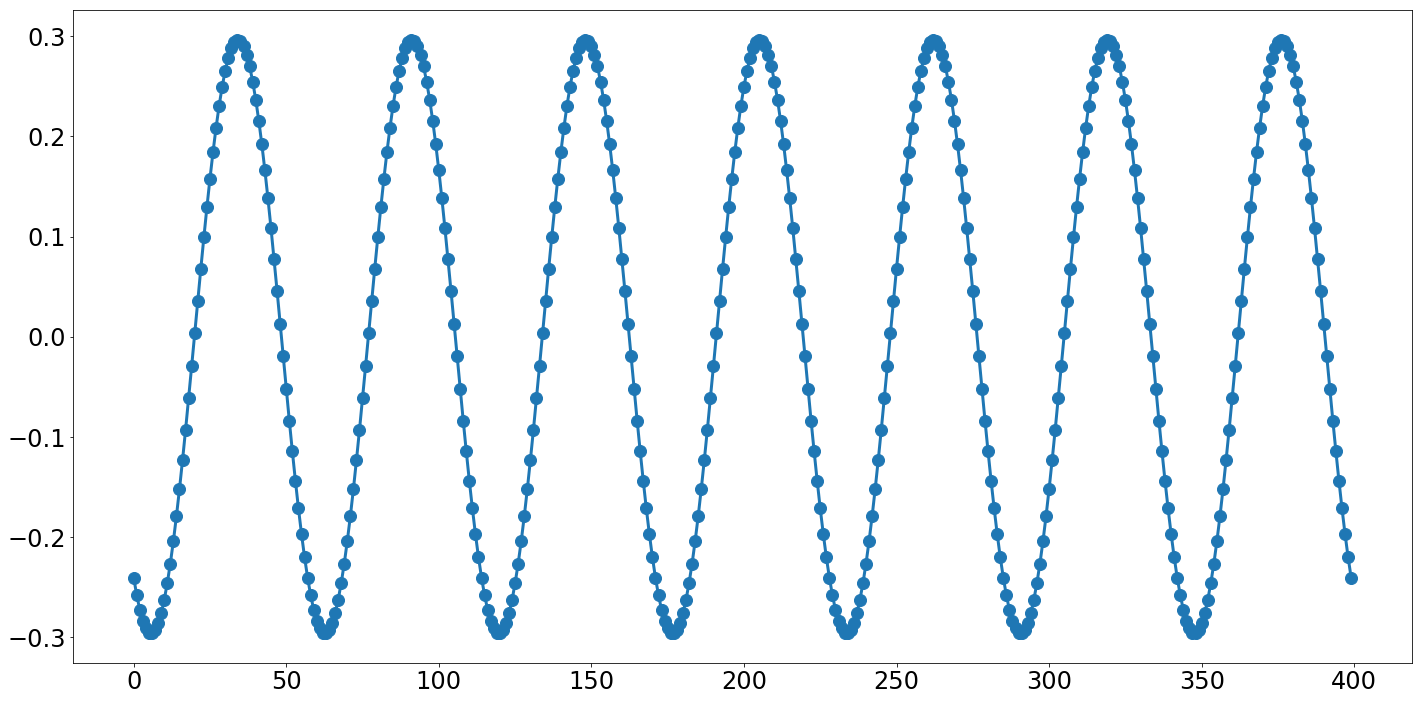

In [6]:
plt.plot(X_test[0], '-o')

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional = False, device = 'cpu'):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.linear = nn.Linear(self.num_direction*hidden_dim, input_dim)
        
        self.to(device)
        
    def forward(self, input):
        input = torch.transpose(input, 0, 1)
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        
        h = encoder_h
        c = encoder_c
        d = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        output = self.linear(encoder_out)
        
        return output, encoder_out, h, c, d

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, a_hidden_dim = None, bidirectional = False, device = 'cpu'):
        super(Decoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.linear = nn.Linear(self.num_direction*hidden_dim, input_dim)
        
        self.to(device)
        
    def forward(self, input, e, h, c, d, max_len = 50, time_len_encoder = 100):
        input = torch.transpose(input, 0, 1)
        answers = torch.zeros(max_len, input.shape[1], self.input_dim).to(self.device)
        decoder_out = torch.zeros(max_len, input.shape[1], self.hidden_dim*self.num_direction).to(self.device)

        for i in range(max_len):
            d, (h, c) = self.decoder(input, (h, c))
            input = self.linear(d)
        
            decoder_out[i] = d[0]
            answers[i] = input[0]
        
        output = torch.transpose(answers, 0, 1)
        decoder_out = torch.transpose(decoder_out, 0, 1)
        
        return output, decoder_out
    
    
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, a_hidden_dim = None, num_layers=1, bidirectional = False, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=bidirectional, device = device)
        self.decoder = Decoder(input_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers, a_hidden_dim = a_hidden_dim, bidirectional = bidirectional, device = device)
    
        self.to(device)
    
    def forward(self, input, max_len = 50):
        
        answers_enc, encoder_out, h, c, d = self.encoder(input)
        
        r = input.shape[1]
        
        answer = input[:, r-1:, :]
        answers_dec, decoder_out = self.decoder(answer, encoder_out, h, c, d, max_len, input.shape[1])
        
        return answers_enc, answers_dec, encoder_out, decoder_out
    

In [8]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    """
    x_batch has a shape [batch_size, time_len_in, input_dim]
    y_batch has a shape [batch_size, time_len_out, time_len_in]
    """
    model.zero_grad()

    r = np.random.randint(30, 2*x_batch.shape[1]//3)
    ind = np.random.randint(r + 1, r+r//2)
    input_batch = x_batch[:, :r, :]
    output_batch = y_batch[:, r:ind, :]
    
    answers_enc, answers_dec, alphas, encoder_out, decoder_out = model.forward(input_batch, max_len = output_batch.shape[1])
    
    loss = loss_function(answers_dec, output_batch)
#     loss += loss_function(answers_enc, input_batch)
    
    loss.backward()

    optimizer.step()

    return loss.detach()

def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    model.train()
    loss = torch.zeros(1).to(str(model.device))
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        if callback is not None:
            callback(model, loss)
    return

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None
           ):

    optima = optimizer(model.parameters(), lr = lr)
    
    for it in tqdm(range(count_of_epoch)):

        batch_generator = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima, callback=callback)

    return

In [9]:
loss_fuction = torch.nn.MSELoss()
optimizer = torch.optim.Adam

dataset = TimeSeries(X_train, X_train, device = device)

In [10]:
model = seq2seq(input_dim = 1,
                hidden_dim = 2,
                output_dim = 1,
                a_hidden_dim = 4,
                device = device)

In [11]:
# trainer(count_of_epoch = 40,
#         batch_size = 64,
#         dataset = dataset,
#         model = model,
#         loss_function = loss_fuction,
#         optimizer = optimizer,
#         lr = 0.001,
#         callback = call
#        )

In [12]:
r = 2*X_test[:1].shape[1]//3
ind = X_test[:1].shape[1]
X = X_test[1:2][:, :r, :]
Y = X_test[1:2][:, r:ind, :]

X = torch.Tensor(2*X).to(device)
Y = torch.Tensor(2*Y).to(device)



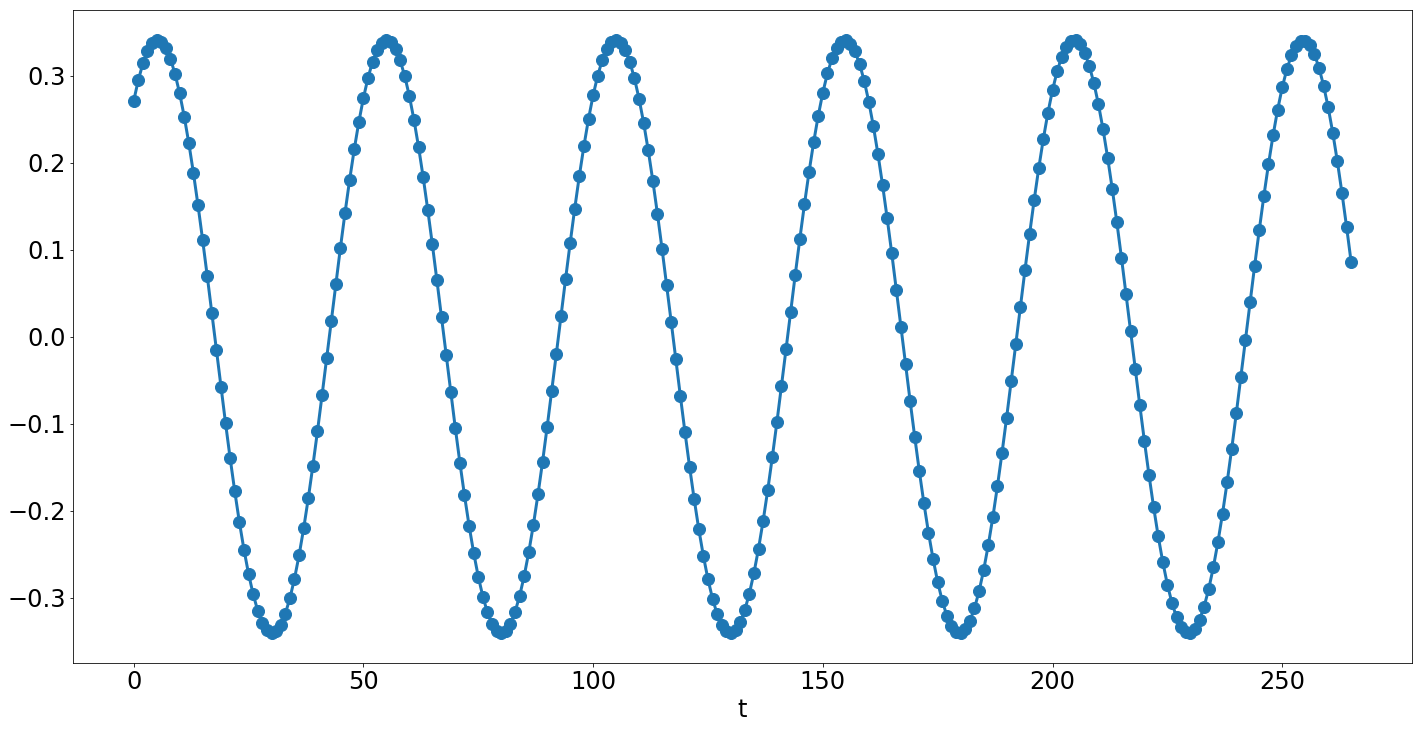

In [13]:
plt.plot(np.reshape(X.cpu().data.numpy(), [-1]), '-o')

plt.xlabel('t')
plt.show()



In [14]:
answers_enc, answers, encoder_out, decoder_out = model(X, max_len = Y.shape[1])



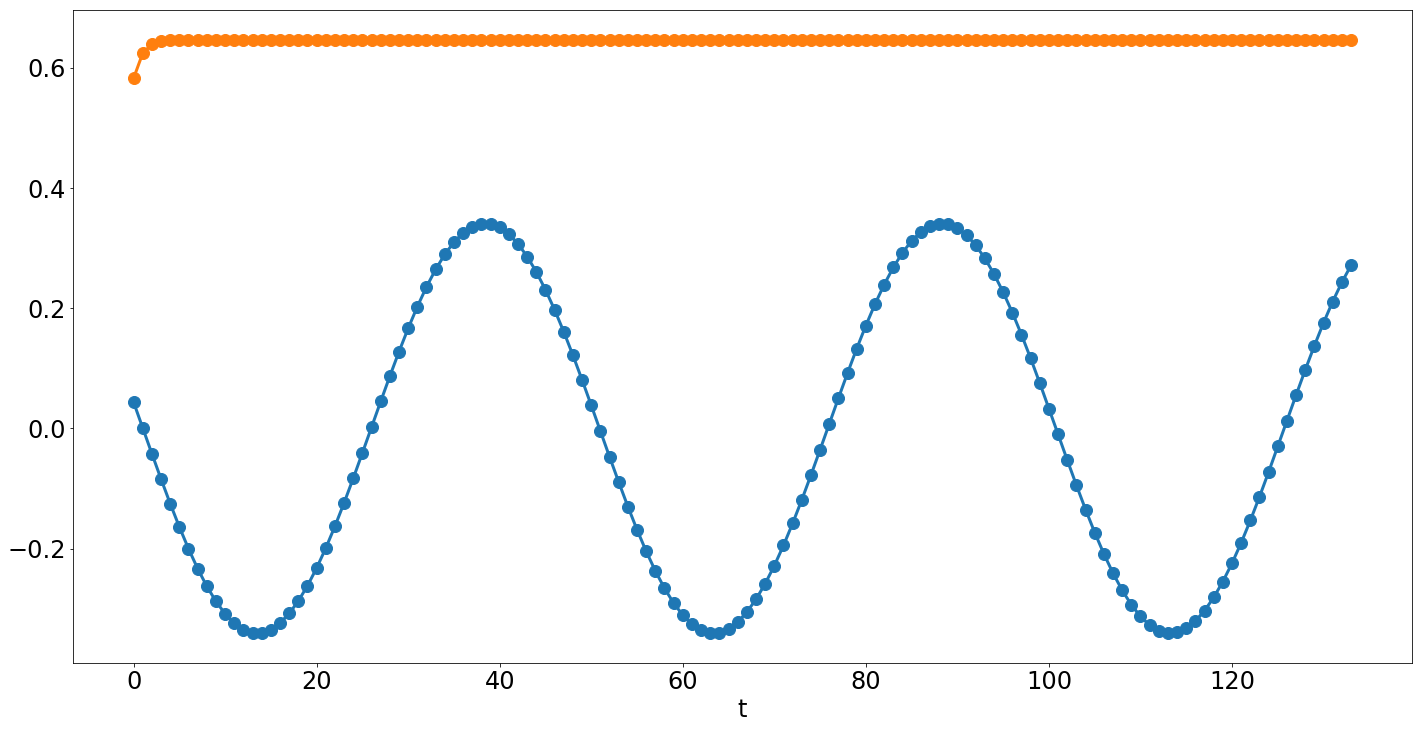

In [15]:
plt.plot(np.reshape(Y.cpu().data.numpy(), [-1]), '-o')
plt.plot(np.reshape(answers.cpu().data.numpy(), [-1]), '-o')

plt.xlabel('t')
plt.show()



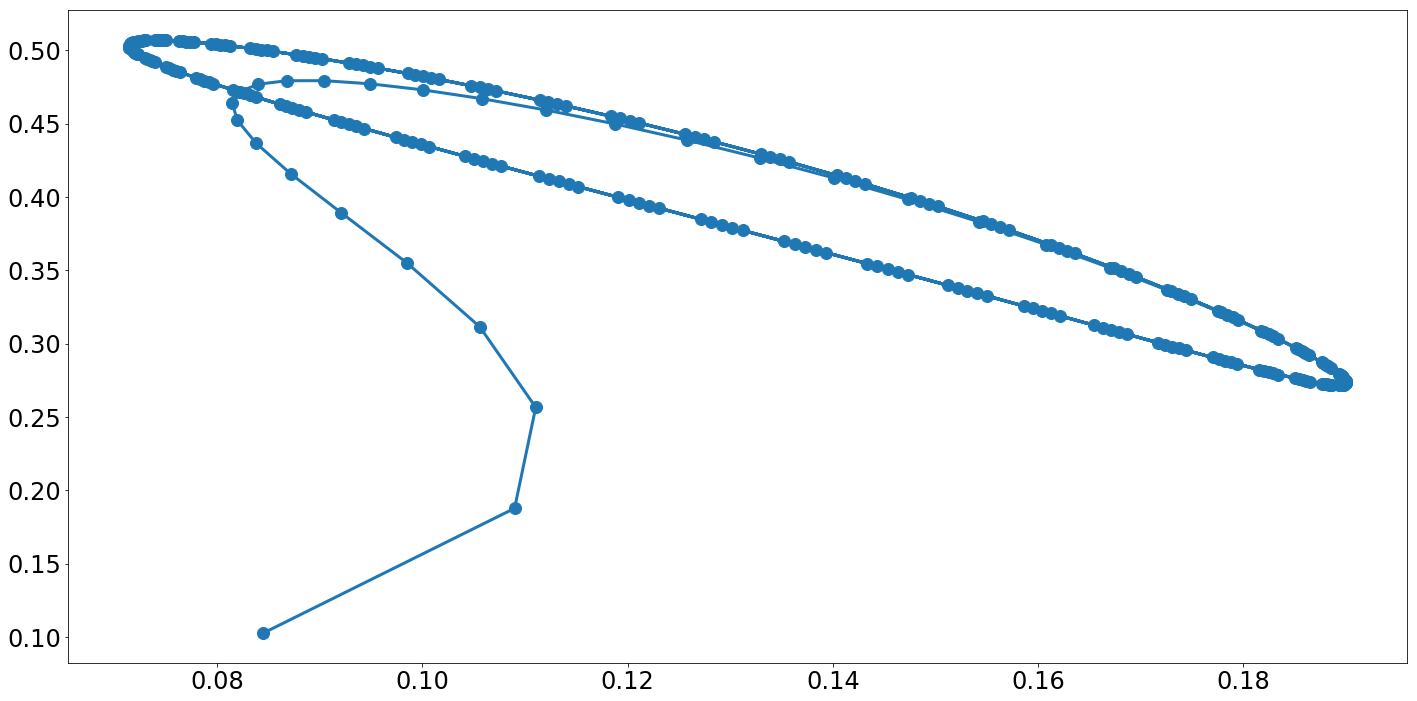

In [16]:
h = encoder_out.cpu().data.numpy()[0]
plt.plot(h[:, 0], h[:, 1], '-o')



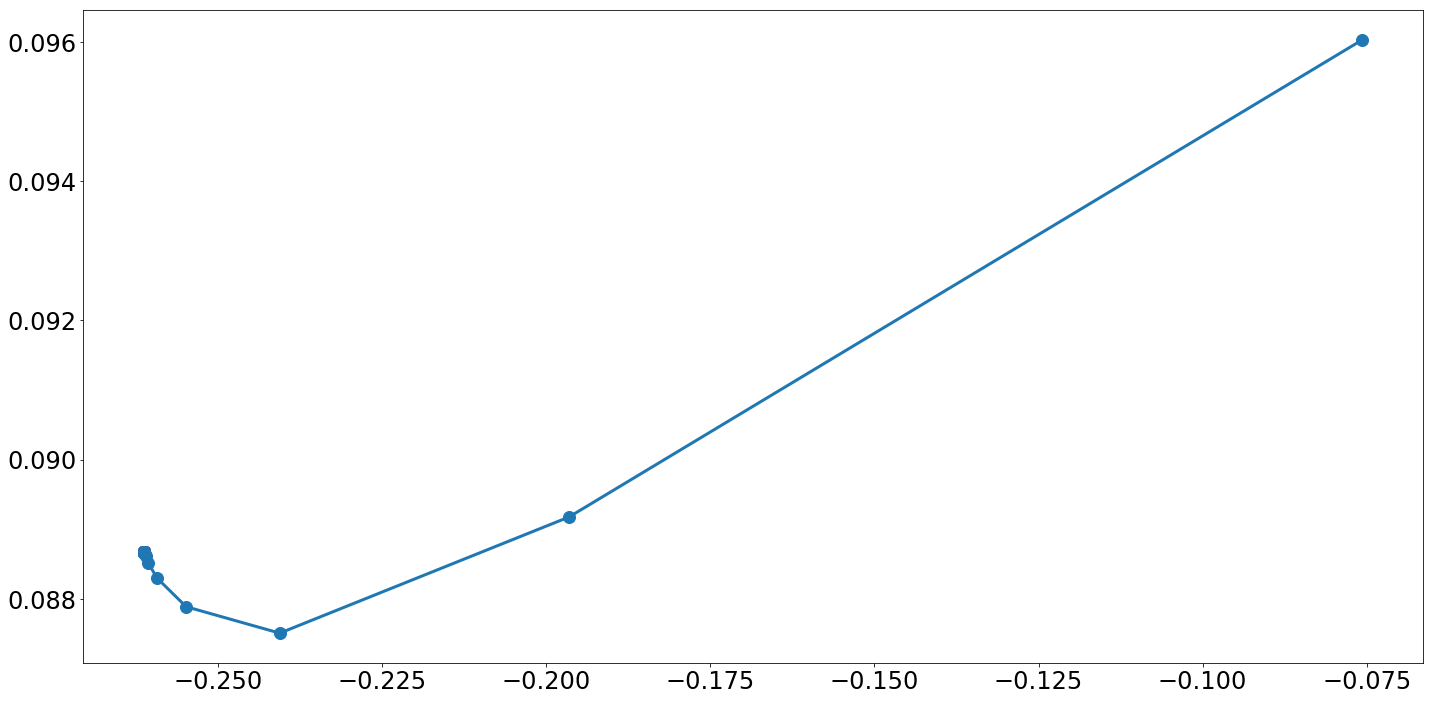

In [17]:
h = decoder_out.cpu().data.numpy()[0]
plt.plot(h[:, 0], h[:, 1], '-o')

